In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv(
    "/content/IMDB Dataset.csv",
    engine="python",

    on_bad_lines="skip"
)


In [4]:
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [5]:
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['sentiment'])


In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define stopwords but keep important negations
stop_words = set(stopwords.words('english'))
negations = {'not', 'no', 'never'}
stop_words = stop_words - negations

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text, flags=re.MULTILINE)

    # Remove punctuation (keep spaces)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back to string
    text = ' '.join(tokens)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
train_df['cleaned_text'] = train_df["review"].apply(lambda x: clean_text(x))
test_df['cleaned_text'] = test_df["review"].apply(lambda x: clean_text(x))

In [9]:
train_df.head(3)

,review,sentiment,cleaned_text
47808,I caught this little gem totally by accident b...,positive,caught little gem totally accident back reviva...
20154,I can't believe that I let myself into this mo...,negative,believe let movie accomplish favor friends ask...
43069,*spoiler alert!* it just gets to me the nerve ...,negative,spoiler alert gets nerve people remake use ter...


In [10]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [11]:
vocab = {'<UNK>':0}

In [12]:
def build_vocab(sentence):
  for word in word_tokenize(sentence):
    if word not in vocab:
      vocab[word] = len(vocab)


In [13]:
for text in train_df["cleaned_text"]:
    build_vocab(text)

for text in test_df["cleaned_text"]:
    build_vocab(text)


In [14]:
# 3️⃣ Convert text to indices
def text_to_indices(text, vocab):
    indexed_text = []
    for word in word_tokenize(text):
        if word in vocab:
            indexed_text.append(vocab[word])
        else:
            indexed_text.append(vocab['<UNK>'])
    return indexed_text

In [15]:
text_to_indices("great movie",vocab)

[411, 80]

In [16]:
import torch
from torch.utils.data import Dataset,DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, vocab, targets):
        self.data = data
        self.vocab = vocab
        self.targets = [1 if sentiment == 'positive' else 0 for sentiment in targets] # Convert sentiment strings to numerical labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq = text_to_indices(self.data[idx], self.vocab)
        seq_tensor = torch.tensor(seq)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return seq_tensor, target

In [17]:
train_dataset = CustomDataset(train_df["cleaned_text"].tolist(), vocab,train_df["sentiment"].tolist())
test_dataset = CustomDataset(test_df["cleaned_text"].tolist(), vocab,test_df["sentiment"].tolist())

In [18]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return sequences_padded, labels


In [19]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=collate_fn,pin_memory=True,num_workers=2)
test_dataloader =  DataLoader(test_dataset, batch_size=32, shuffle=False,collate_fn=collate_fn,pin_memory=True,num_workers=2)


In [20]:
for batch,label in train_dataloader:
  print(batch)
  print(label)
  break

tensor([[    4,  4338,  1777,  ...,     0,     0,     0],
        [31731,    93,    57,  ...,     0,     0,     0],
        [ 1043,  3824,   799,  ...,     0,     0,     0],
        ...,
        [ 1267,  8993,   211,  ...,     0,     0,     0],
        [ 4633,  4435,    71,  ...,     0,     0,     0],
        [12681,   483,  3805,  ...,     0,     0,     0]])
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 0])


In [21]:
import torch.nn as nn

In [22]:
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(vocab), embedding_dim)) # random embedding bana le agar glove mein word na hoa fallback ke liye
    with open(glove_path, 'r', encoding='utf8') as f: # glove file ko open kia
        for line in f: # line by line read kia
            values = line.split() # line ko split kia
            if len(values) == embedding_dim + 1: # Check if the number of values matches the expected dimension + 1 (for the word)
                word = values[0] # line mein se word ko extract kia
                if word in vocab: # check kia ke wo word vocab mein hai ya ni
                    vector = np.asarray(values[1:], dtype='float32') # word ke jo values hain embedding ke unko string se conver kia f
                    embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# Example
embedding_matrix = load_glove_embeddings("glove.6B.100d.txt", vocab)
embedding_matrix = embedding_matrix.to(device)



In [82]:

class ImdbModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, embedding_matrix=None, freeze=False, dropout=0.4):
        super(ImdbModel, self).__init__()

        if embedding_matrix is not None:
            # Pretrained embeddings
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze)
        else:
            # Random initialization
            self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, bidirectional=True)

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = lstm_out[:, -1, :]  # last timestep

        out = self.dropout(out)   # apply dropout before classification
        out = self.fc(out)
        return out.squeeze(1)

In [83]:
model = ImdbModel(
    vocab_size=len(vocab),
    embed_dim=100,
    hidden_size=128,
    embedding_matrix=embedding_matrix,  # use pretrained
    freeze=False,
    dropout=0.4

)

In [84]:
model = model.to(device)

In [85]:
learning_rate = 0.001


In [90]:
criterion = nn.BCEWithLogitsLoss()  # Change criterion to BCEWithLogitsLoss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min", patience=2, factor=0.5)



In [60]:
from sklearn.metrics import f1_score


Epoch 1/10 | Train Loss: 0.5161, Train Acc: 0.7826 | Test Loss: 0.6127, Test Acc: 0.6882, F1: 0.5706
Epoch 2/10 | Train Loss: 0.5038, Train Acc: 0.7853 | Test Loss: 0.5643, Test Acc: 0.6529, F1: 0.5248
Epoch 3/10 | Train Loss: 0.3111, Train Acc: 0.8743 | Test Loss: 0.2702, Test Acc: 0.8907, F1: 0.8938
Epoch 4/10 | Train Loss: 0.1626, Train Acc: 0.9439 | Test Loss: 0.2720, Test Acc: 0.8956, F1: 0.8965
Epoch 5/10 | Train Loss: 0.0734, Train Acc: 0.9802 | Test Loss: 0.3465, Test Acc: 0.8888, F1: 0.8882


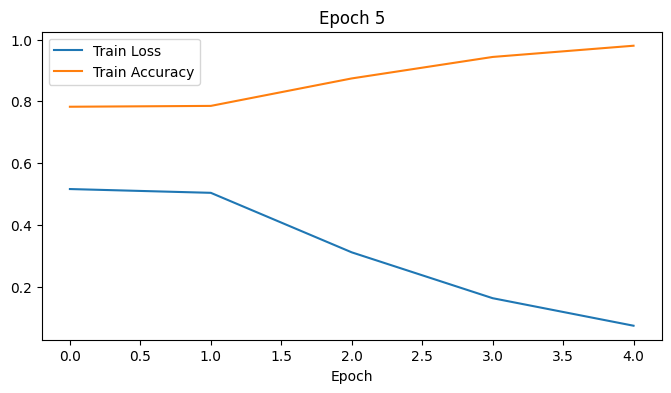

Epoch 6/10 | Train Loss: 0.0386, Train Acc: 0.9921 | Test Loss: 0.4542, Test Acc: 0.8860, F1: 0.8871
Epoch 7/10 | Train Loss: 0.0236, Train Acc: 0.9962 | Test Loss: 0.5877, Test Acc: 0.8857, F1: 0.8863
Epoch 8/10 | Train Loss: 0.0195, Train Acc: 0.9971 | Test Loss: 0.6071, Test Acc: 0.8777, F1: 0.8759
Epoch 9/10 | Train Loss: 0.0180, Train Acc: 0.9975 | Test Loss: 0.6510, Test Acc: 0.8762, F1: 0.8725
💾 Final model saved (Epoch 10) | Test Acc: 0.8784
Epoch 10/10 | Train Loss: 0.0143, Train Acc: 0.9981 | Test Loss: 0.6751, Test Acc: 0.8784, F1: 0.8791


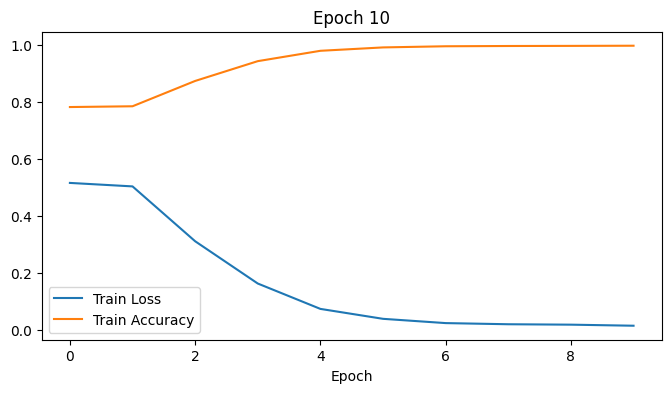

In [92]:
# ------------------------
# 1. Setup
# ------------------------
epochs = 10
epoch_losses = []
epoch_acc = []
best_acc = 0.0

# ------------------------
# 2. Training Loop
# ------------------------
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_seq, batch_labels in train_dataloader:
        batch_seq = batch_seq.to(device)
        batch_labels = batch_labels.to(device).float()

        optimizer.zero_grad()
        outputs = model(batch_seq)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.round(torch.sigmoid(outputs))
        correct += (preds == batch_labels).sum().item()
        total += batch_labels.size(0)

    train_loss = total_loss / len(train_dataloader)
    train_acc = correct / total

    # ------------------------
    # 3. Evaluation
    # ------------------------
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    total_test_loss = 0

    with torch.no_grad():
        for batch_seq, batch_labels in test_dataloader:
            batch_seq = batch_seq.to(device)
            batch_labels = batch_labels.to(device).float()

            outputs = model(batch_seq)
            loss = criterion(outputs, batch_labels)
            total_test_loss += loss.item()

            preds = torch.round(torch.sigmoid(outputs))
            test_correct += (preds == batch_labels).sum().item()
            test_total += batch_labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    test_loss = total_test_loss / len(test_dataloader)
    test_acc = test_correct / test_total
    test_f1 = f1_score(all_labels, all_preds)

    # ------------------------
    # 4. Scheduler & Save Best Model
    # ------------------------
    scheduler.step(test_loss)  # reduce LR if test_loss plateaus

    if epoch == epochs - 1:
       torch.save(model.state_dict(), "best_model.pth")
       print(f"💾 Final model saved (Epoch {epoch+1}) | Test Acc: {test_acc:.4f}")


    # ------------------------
    # 5. Logging
    # ------------------------
    epoch_losses.append(train_loss)
    epoch_acc.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, F1: {test_f1:.4f}")

    if (epoch+1) % 5 == 0:
        plt.figure(figsize=(8,4))
        plt.plot(epoch_losses, label='Train Loss')
        plt.plot(epoch_acc, label='Train Accuracy')
        plt.title(f'Epoch {epoch+1}')
        plt.xlabel('Epoch')
        plt.legend()
        plt.show()

In [113]:
def predict(model, review, vocab, threshold=0.5):
    """
    Predict sentiment of a review using a trained IMDB LSTM model.

    Args:
        model: trained PyTorch model
        review: str or list of tokens
        vocab: vocabulary dict {word: index}
        threshold: float, decision threshold for positive class

    Returns:
        "positive" or "negative"
    """
    # Ensure review is list of tokens
    if isinstance(review, str):
        cleaned_review = clean_text(review) # Clean the text first
        tokens = cleaned_review  # Use the cleaned text for tokenization
    elif isinstance(review, list):
        tokens = review  # already tokenized (assuming it's already cleaned)
    else:
        raise TypeError("Review must be a string or list of tokens")

    # Convert tokens to indices
    num_review = text_to_indices(tokens, vocab)  # implement this function to map tokens → indices

    # Convert to tensor
    review_tensor = torch.tensor(num_review).unsqueeze(0).to(next(model.parameters()).device)  # shape [1, seq_len]

    model.eval()
    with torch.no_grad():
        output = model(review_tensor)             # raw logits
        prediction = torch.sigmoid(output).item() # convert to probability
        print(f"Prediction score: {prediction:.4f}")

    return "positive" if prediction > threshold else "negative" if prediction < 1 - threshold else "neutral"

In [114]:
reviews = [
    "The movie started strong but got slower and confusing toward the end.",
    "Good performances, but the story didn’t leave much of an impact.",
    "It had some funny moments, though overall it felt a bit too long.",
    "The direction was okay, not great, but definitely not bad either.",
    "Some parts were emotional, but others were plain dull and repetitive.",
    'the movie was so bad i wasted my time to watch this such a bad acting plz refund my money bad bad bad',
]


for i, review in enumerate(reviews, 1):
    result = predict(model, review, vocab, threshold=0.5)  # use the loaded model
    print(f"Review {i}: {result}")

Prediction score: 0.9784
Review 1: positive
Prediction score: 0.9586
Review 2: positive
Prediction score: 0.9436
Review 3: positive
Prediction score: 0.0059
Review 4: negative
Prediction score: 0.3770
Review 5: negative
Prediction score: 0.0004
Review 6: negative
